In [74]:
import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical operations
import cv2  # openCvfor computer vision tasks
from PIL import Image
import PIL  # python imaging library for image processing
import matplotlib.pyplot as plt  # for creating plots and visualisations
import seaborn as sns  # statistical data visualization
import random  # for generating random numbers
import os  # for interacting with operating system
# get_ipython().run_line_magic('matplotlib', 'inline')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import time
from concurrent.futures import ThreadPoolExecutor
# Display some images
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

set seed for reproducibility

In [2]:
random.seed(100)
np.random.seed(100)

In [3]:
dicom_data = pd.read_csv('input/csv/dicom_info.csv')

In [4]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


Filter 'dicom_data' DataFrame to select rows where 'SeriesDescription' is 'cropped images'

In [5]:
cropped_images = dicom_data.loc[dicom_data["SeriesDescription"] == 'cropped images']["image_path"]

Set the directory path for JPEG images

In [6]:
image_dir = 'input/jpeg'

In [7]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [8]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [9]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))

In [10]:
mass_case_df = pd.read_csv("input/csv/mass_case_description_train_set.csv")
# Read CSV files into DataFrames
mass_case_test_df = pd.read_csv('input/csv/mass_case_description_test_set.csv')

**Data cleaning**

In [11]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [12]:
dicom_cleaned_data.drop(['PatientBirthDate', 'AccessionNumber', 'Columns', 'ContentDate', 'ContentTime',
                         'PatientSex', 'PatientBirthDate', 'ReferringPhysicianName', 'Rows', 'SOPClassUID',
                         'SOPInstanceUID',
                         'StudyDate', 'StudyID', 'StudyInstanceUID', 'StudyTime', 'InstanceNumber', 'SeriesInstanceUID',
                         'SeriesNumber'
                         ], axis=1, inplace=True)

In [13]:
dicom_cleaned_data['SeriesDescription'].ffill(inplace=True)
dicom_cleaned_data['Laterality'].bfill(inplace=True)
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

Create a copy of 'data_2_test' DataFrame for cleaning

In [14]:
Data_cleaning_2_test = mass_case_test_df.copy()

Rename columns in 'Data_cleaning_2_test' DataFrame

In [15]:
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass shape': 'mass_shape'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast': 'left_or_right_breast'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass margins': 'mass_margins'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'image view': 'image_view'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'abnormality type': 'abnormality_type'})
# Convert specified columns in 'Data_cleaning_2_test' to the 'category' data type
Data_cleaning_2_test['left_or_right_breast'] = Data_cleaning_2_test['left_or_right_breast'].astype('category')
Data_cleaning_2_test['image_view'] = Data_cleaning_2_test['image_view'].astype('category')
Data_cleaning_2_test['mass_margins'] = Data_cleaning_2_test['mass_margins'].astype('category')
Data_cleaning_2_test['mass_shape'] = Data_cleaning_2_test['mass_shape'].astype('category')
Data_cleaning_2_test['abnormality_type'] = Data_cleaning_2_test['abnormality_type'].astype('category')
Data_cleaning_2_test['pathology'] = Data_cleaning_2_test['pathology'].astype('category')
# Display the count of missing values in each column of 'Data_cleaning_2_test' DataFrame
Data_cleaning_2_test.isna().sum()
# Fill missing values in 'mass_margins' column of 'Data_cleaning_2_test' DataFrame using backward fill
Data_cleaning_2_test['mass_margins'].fillna(method='bfill', axis=0, inplace=True)
# Display the count of missing values in each column of 'Data_cleaning_2' DataFrame
Data_cleaning_2_test.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [16]:
Data_cleaning_2 = mass_case_df.copy()

In [17]:
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape': 'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast': 'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins': 'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view': 'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type': 'abnormality_type'})

In [18]:
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [19]:
Data_cleaning_2['mass_shape'].bfill(inplace=True)
Data_cleaning_2['mass_margins'].bfill(inplace=True)
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

Print the original column names in Data_cleaning_2 DataFrame

In [20]:
print(Data_cleaning_2.columns)
print('\n')
# Rename selected columns in Data_cleaning_2 DataFrame for better clarity
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast': 'left_or_right_breast',
                                                  'image view': 'image_view',
                                                  'abnormality id': 'abnormality_id',
                                                  'abnormality type': 'abnormality_type',
                                                  'mass shape': 'mass_shape',
                                                  'mass margins': 'mass_margins',
                                                  'image file path': 'image_file_path',
                                                  'cropped image file path': 'cropped_image_file_path',
                                                  'ROI mask file path': 'ROI_mask_file_path'})

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




Display the updated column names in Data_cleaning_2 DataFrame

In [21]:
print(Data_cleaning_2["image_file_path"].unique().tolist()[1])

Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm


In [22]:
print(Data_cleaning_2_test.columns)
print('\n')
# Rename selected columns in Data_cleaning_2_test DataFrame for better clarity
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                                            'image view': 'image_view',
                                                            'abnormality id': 'abnormality_id',
                                                            'abnormality type': 'abnormality_type',
                                                            'mass shape': 'mass_shape',
                                                            'mass margins': 'mass_margins',
                                                            'image file path': 'image_file_path',
                                                            'cropped image file path': 'cropped_image_file_path',
                                                            'ROI mask file path': 'ROI_mask_file_path'})

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




Display the updated column names in Data_cleaning_2_test DataFrame

In [23]:
print(Data_cleaning_2_test.columns)

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')


organize image paths

In [24]:
full_mammo_dict = dict()
cropped_images_dict = dict()
# Iterate through full_mammogram_images and create a dictionary with keys based on unique identifiers
for dicom in full_mammogram_images:
    key = dicom.split("/")[2]
    full_mammo_dict[key] = dicom
# Iterate through cropped_images and create a dictionary with keys based on unique identifiers
for dicom in cropped_images:
    key = dicom.split("/")[2]
    cropped_images_dict[key] = dicom

Display the keys of the first item in full_mammo_dict

In [25]:
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 'input/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

fix image paths

In [26]:
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index, 11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index, 12] = cropped_images_dict[img_name]

apply to datasets

In [27]:
fix_image_path(Data_cleaning_2)
fix_image_path(Data_cleaning_2_test)

create function to display images

# Data Preprocessing

In [28]:
tf.random.set_seed(100)

Define a classification dictionary for pathology

In [29]:
classification = {"MALIGNANT": 0, "BENIGN_WITHOUT_CALLBACK": 1, "BENIGN": 1}

In [48]:
def load_image(img):
    # Load and resize the image
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    return c_img_size

In [49]:
def get_pathology(pathology):
    return classification[pathology]

In [50]:
def get_images_result(dataset):
    with ThreadPoolExecutor() as executor:
        # Load images and get pathology results using parallel processing
        images = np.array(list(executor.map(load_image, dataset.loc[:]['image_file_path'])))
        result = np.array(list(executor.map(get_pathology, dataset.loc[:]['pathology'])))
    # Convert pathology results to categorical format
    result = to_categorical(result)
    return images, result

In [51]:
mass_train_data_shuffled = Data_cleaning_2.sample(frac=1)
mass_test_data_shuffled = Data_cleaning_2_test.sample(frac=1)
tic = time.perf_counter()
(X_train, y_train) = get_images_result(mass_train_data_shuffled)
(X_test, y_test) = get_images_result(mass_test_data_shuffled)
toc = time.perf_counter()
print(f"Uploading the images and resizing in {toc - tic:0.4f} seconds")
print('X_train shape : {}'.format(X_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y_test shape : {}'.format(y_test.shape))

Uploading the images and resizing in 23.9653 seconds
X_train shape : (1318, 50, 50, 3)
y_train shape : (1318, 2)
X_test shape : (378, 50, 50, 3)
y_test shape : (378, 2)


Full Mammograms:



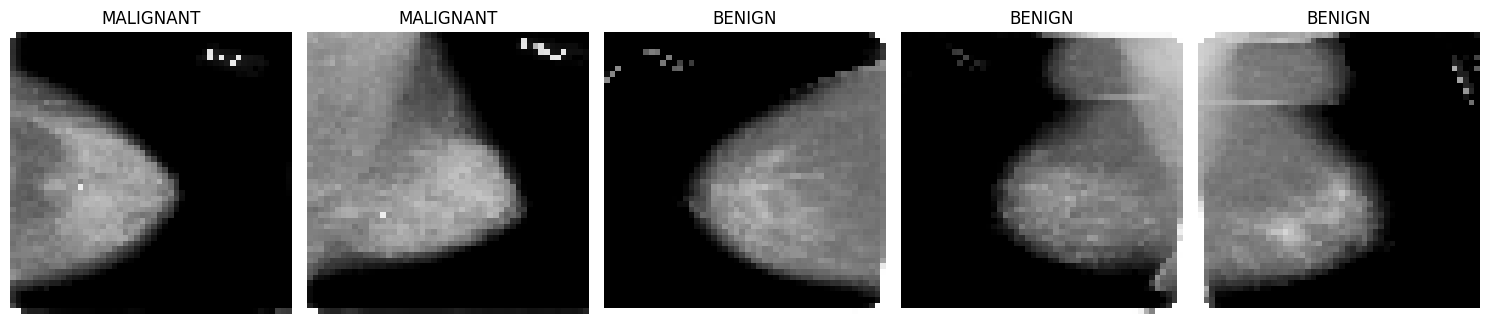

Cropped Mammograms:



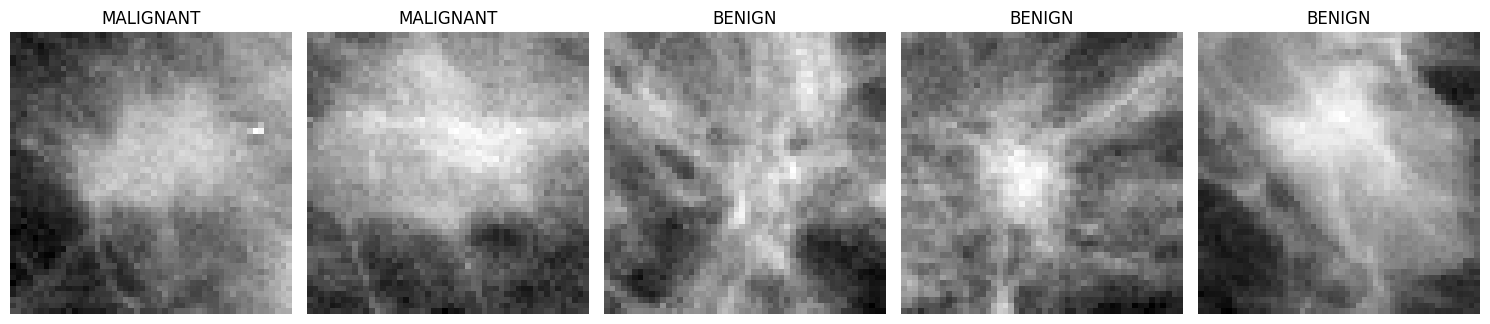

In [56]:
# create function to display images
def display_images(column, number):
    """displays images in the dataset"""
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in Data_cleaning_2.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        image = cv2.resize(image, (50, 50), interpolation=cv2.INTER_LINEAR)
        col_index = index % cols  # Calculate the correct column index
        ax = axes[col_index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)

## FINE TUNE

In [2]:
from tensorflow import keras
base_model = keras.models.load_model("input/model_breastHistoryDataset_Cnn.h5")

2024-08-03 12:25:50.139564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 12:25:50.184824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-03 12:25:50.185020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [8]:
base_model.layers[-4]

In [7]:
inputs = keras.Input(shape=(50,50,3))
print(inputs.shape)

(None, 50, 50, 3)


In [10]:
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

for layer in base_model.layers[:-4]:
    x = base_model.get_layer(layer.name)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
fine_tuned_model = keras.Model(inputs, outputs)

fine_tuned_model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         Y          
                                                                            
 rescaling (Rescaling)       (None, 50, 50, 3)         0         Y          
                                                                            
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       Y          
                                                                            
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         Y          
 2D)                                                                        
                                                                            
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        18496     Y          
                                                             

In [87]:
base_model.trainable = False

scale_layer = tf.keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(inputs)
print(x.shape)
x = base_model(x, training=False, include_top=False)

print(x.shape)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

(None, 50, 50, 3)
(None, 50, 50, 3)


TypeError: Sequential.call() got an unexpected keyword argument 'include_top'

In [40]:
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Increase the number of neurons in the dense layer
    model.add(Dropout(0.2))  # Adjust dropout rate
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    # Compile the model with a lower learning rate
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return model, early_stopping

In [43]:
cnn_model, early_stopping = create_cnn_model(input_shape=(224, 224, 3))
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-07-27 09:30:17.355848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 09:30:17.438930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 09:30:17.439568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [44]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [44]:
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test),
                         callbacks=early_stopping)

Print the final accuracy and loss

In [ ]:
final_loss, final_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Final Validation Loss: {final_loss:.4f}')
print(f'Final Validation Accuracy: {final_accuracy:.4f}')

In[31]:

Save the trained model to a file

In [ ]:
cnn_model.save("cnn_model.h5")
print("Model saved to disk.")

Load the model back (optional)

In [ ]:
loaded_model = load_model("cnn_model.h5")

## DenseNet121-cbis ddsm breast cancer dataset

In[32]:

In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
def create_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return model, early_stopping

Reshape the input data

In [ ]:
input_shape_densenet = (224, 224, 3)

Create and compile the modified DenseNet121 model

In [ ]:
densenet_model, early_stopping_densenet = create_densenet_model(input_shape_densenet)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

Train the model

In [ ]:
history_densenet = densenet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30,
                                      validation_data=(X_test, y_test), callbacks=[early_stopping_densenet])

Evaluate the model

In [ ]:
final_loss_densenet, final_accuracy_densenet = densenet_model.evaluate(X_test, y_test)
print(f'Final Validation Loss (DenseNet): {final_loss_densenet:.4f}')
print(f'Final Validation Accuracy (DenseNet): {final_accuracy_densenet:.4f}')

Save the DenseNet model to an h5 file

In [ ]:
densenet_model.save('denseNet_model_cbis.h5')
print("DenseNet121 Model saved to disk.")

# EfficientNetB0 Cbis

In[33]:

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Define the modified model with EfficientNetB0 base

In [ ]:
def create_efficientnet_model(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return model, early_stopping

Reshape the input data

In [ ]:
input_shape_efficientnet = (224, 224, 3)

Create and compile the modified EfficientNetB0 model

In [ ]:
efficientnet_model, early_stopping_efficientnet = create_efficientnet_model(input_shape_efficientnet)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

Train the model

In [ ]:
history_efficientnet = efficientnet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30,
                                              validation_data=(X_test, y_test), callbacks=[early_stopping_efficientnet])

Evaluate the model

In [ ]:
final_loss_efficientnet, final_accuracy_efficientnet = efficientnet_model.evaluate(X_test, y_test)
print(f'Final Validation Loss (EfficientNetB0): {final_loss_efficientnet:.4f}')
print(f'Final Validation Accuracy (EfficientNetB0): {final_accuracy_efficientnet:.4f}')

Save the modified EfficientNetB0 model to a h5 file

In [ ]:
efficientnet_model.save('efficientnetb0_model_cbis.h5')
print("Modified EfficientNetB0 Model saved to disk.")

In [2]:
base_directory = 'breast-histopathology-images/'

In [3]:
breast_img = []

In [4]:
subdirectories = [f.path for f in os.scandir(base_directory) if f.is_dir()]

Her alt dizinde dolaşın ve dosya yollarını ekleyin

In [5]:
for subdirectory in subdirectories:
    for root, dirs, files in os.walk(subdirectory):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                breast_img.append(file_path)

In [7]:
import json
with open('data.json', 'w') as f:
    json.dump(breast_img, f)

İlk birkaç dosyayı gösterin

In [ ]:
for imgname in breast_img[:3]:
    print(imgname)

In[35]:

In [ ]:
non_can_img = []  # non-cancerous (kansersiz) listesi
can_img = []  # cancerous (kanserli) listesi
for img in breast_img:
    if img[-5] == '0':
        non_can_img.append(img)
    elif img[-5] == '1':
        can_img.append(img)

In [ ]:
non_can_num = len(non_can_img)  # No cancer
can_num = len(can_img)  # Cancer

In [ ]:
total_img_num = non_can_num + can_num

In [ ]:
print('Number of Images of no cancer: {}'.format(non_can_num))
print('Number of Images of cancer : {}'.format(can_num))
print('Total Number of Images : {}'.format(total_img_num))

In[36]:

listelerinden rastgele örnekler alır

In [ ]:
max_samples = 20000  # zamandan tasrruf için örnek sayısını sınırladık
some_non_img = random.sample(non_can_img, min(len(non_can_img), max_samples))  # kansersiz görüntülerin dosya yolu
some_can_img = random.sample(can_img, min(len(can_img), max_samples))  # kanserli görüntülerin dosya yolu

In [ ]:
non_img_arr = []
can_img_arr = []

Her iki kategoriye ait görüntüleri küçültür ve renkli görüntüleri siyah-beyaz formatına dönüştürür.<br>
Her bir görüntüyü (50x50 piksel boyutunda) içeren bir liste oluşturur ve bu listeye etiketi (0 veya 1) ekler.

In [ ]:
for img in some_non_img:  # kansersiz görüntülerin işlenmesi başlar.
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)  # OpenCV kullanılarak resim dosyası okunur.
    n_img_size = cv2.resize(n_img, (50, 50),
                            interpolation=cv2.INTER_LINEAR)  # Okunan resim, 50x50 piksel boyutuna küçültülür
    non_img_arr.append([n_img_size, 0])  # Küçültülen resim, etiketi (0) ile birlikte non_img_arr listesine eklenir.
    confusion_matrix
for img in some_can_img:  # kanserli görüntülerin işlenmesi başlar.
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

Listeler birleştirelim

In [ ]:
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(
    breast_img_arr)  # Birleştirilen liste karıştırılır.Bu, öğrenme algoritmalarına eğitim verilerini daha iyi sunmak için önemlidir.

In[37]:

In [ ]:
X = []
y = []

özellik ve etiket için listeden örnek döndürelim.

In [ ]:
for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

 NumPy dizilerine dönüştürelim.

In [ ]:
X = np.array(X)
y = np.array(y)

verinin %20'sinin test setine ayrılsın.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Bir azaltma (downsampling) oranı belirlenir. num değişkeni, oran ile çarpılarak eğitim verisinin boyutunu belirler.

In [ ]:
rate = 0.5
num = int(X.shape[0] * rate)

Etiketler one-hot encoding'e dönüştür

In [ ]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
print('X_train shape : {}'.format(X_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y_train shape : {}'.format(y_train.shape))
print('y_test shape : {}'.format(y_test.shape))

## CNN-breast histopathology dataset

In[38]:

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Veriyi artırma için ImageDataGenerator

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Yeni modeli oluşturun

In [ ]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

Modeli derleme

In [ ]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Erken durdurma için geri çağırma

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Veri artırma ve modeli eğitme

In [ ]:
history_cnn = model_cnn.fit(datagen.flow(X_train, y_train, batch_size=75),
                            validation_data=(X_test, y_test),
                            epochs=25,
                            callbacks=[early_stopping])

Modeli değerlendirme

In [ ]:
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_cnn}, Test Accuracy: {test_accuracy_cnn}')

Modeli kaydetme

In [ ]:
model_cnn.save('model_breastHistoryDataset_Cnn.h5')
print("CNN model saved to disk.")

Modeli yükleyerek tahmin yapma

In [ ]:
loaded_model_cnn = tf.keras.models.load_model('model_breastHistoryDataset_Cnn.h5')
predictions_cnn = loaded_model_cnn.predict(X_test)

## EfficientNetB0 - breast histopathology dataset

In[39]:

Veriyi artırma için ImageDataGenerator

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(50, 50, 3))
base_model.trainable = False  # Transfer learning için önceden eğitilmiş ağırlıkları dondurun

Yeni modeli oluşturun

In [ ]:
model_efficientnetb0 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

Learning rate scheduler

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Modeli derleme

In [ ]:
model_efficientnetb0.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Erken durdurma için geri çağırma

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Veri artırma ve modeli eğitme

In [ ]:
history_efficientnetb0 = model_efficientnetb0.fit(datagen.flow(X_train, y_train, batch_size=75),
                                                  validation_data=(X_test, y_test),
                                                  epochs=25,
                                                  callbacks=[early_stopping])

Modeli değerlendirme

In [ ]:
test_loss_efficientnetb0, test_accuracy_efficientnetb0 = model_efficientnetb0.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_efficientnetb0}, Test Accuracy: {test_accuracy_efficientnetb0}')

Modeli kaydetme

In [ ]:
model_efficientnetb0.save('model_breastHistoryDataset_efficientnetb0.h5')
print("EfficientNetB0 model saved to disk.")

Modeli yükleyerek tahmin yapma

In [ ]:
loaded_model_efficientnetb0 = tf.keras.models.load_model('model_breastHistoryDataset_efficientnetb0.h5')
predictions_efficientnetb0 = loaded_model_efficientnetb0.predict(X_test)

## DenseNet121 - breast histopathology dataset

In[40]:

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping

Veriyi artırma için ImageDataGenerator

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(50, 50, 3))
base_model.trainable = False  # Transfer learning için önceden eğitilmiş ağırlıkları dondurun

Yeni modeli oluşturun

In [ ]:
model_densenet121 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

Learning rate scheduler

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Modeli derleme

In [ ]:
model_densenet121.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Erken durdurma için geri çağırma

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Veri artırma ve modeli eğitme

In [ ]:
history_densenet121 = model_densenet121.fit(datagen.flow(X_train, y_train, batch_size=75),
                                            validation_data=(X_test, y_test),
                                            epochs=25,
                                            callbacks=[early_stopping])

Modeli değerlendirme

In [ ]:
test_loss_densenet121, test_accuracy_densenet121 = model_densenet121.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss_densenet121}, Test Accuracy: {test_accuracy_densenet121}')

Modeli kaydetme

In [ ]:
model_densenet121.save('model_breastHistoryDataset_densenet121.h5')
print("DenseNet121 model saved to disk.")

Modeli yükleyerek tahmin yapma

In [ ]:
loaded_model_densenet121 = tf.keras.models.load_model('model_breastHistoryDataset_densenet121.h5')
predictions_densenet121 = loaded_model_densenet121.predict(X_test)

# Karışıklık matrisi (confusion matrix)<br>
Şimdi de model_breastHistoryDataset_cnnin test verisi üzerindeki tahminlerini kullanarak bir karışıklık matrisi (confusion matrix) oluşturalım. Bu matrisi de ısı haritası şeklinde görselleştirelim.

In[41]:

In [ ]:
Y_pred = model_cnn.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In[42]:

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_breastHistoryDataset_cnn Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_breastHistoryDataset_cnn Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In[43]:

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model_breastHistoryDataset_cnn.predict(X_test)

In [ ]:
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

calculate the percentage

In [ ]:
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

In [ ]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# Testing the Model

Define a mapping of class indices to human-readable labels

In [ ]:
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

Define a mapping of calcification types

In [ ]:
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

Define a function for plotting an image from an array

In [ ]:
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')

    # Display the image at the specified index in the array
    plt.imshow(arr[index])

Set the index value to 90

In [ ]:
index = 90

Plot an image from the X_test array using the img_plot function

In [ ]:
img_plot(X_test, index)

Extract a single image from X_test based on the specified index

In [ ]:
input = X_test[index:index + 1]

Make a prediction using the CNN model and get the class with the highest probability

In [ ]:
predicted_class_index = loaded_model_cnn.predict(input)[0].argmax()

Get the true label from the y_test array

In [ ]:
true_class_index = y_test[index].argmax()

Get the predicted and true labels

In [ ]:
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

Get the calcification type based on the predicted class index (modify as needed)

In [ ]:
calcification_type = calcification_types[predicted_class_index]

Print the prediction result with calcification type

In [ ]:
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)